**Markov Chain Monte Carlo**

In this assignment, we will apply a Metropolis-Hastings Markov Chain (MCMC) sampler to type Ia supernova data.

The Data will be from the Supernova Cosmology Project at:
http://supernova.lbl.gov/union/descriptions.html#Magvsz

Background:

The apparent magnitude of an object with luminosity $L$ is

$m = - 2.5 \log\left( \frac{L}{2\pi D_L^2} \right) + m_o = 5 \log\left( D_L \right) + 2.5 \log\left( L \right) + m_o$

where $D_L$ is the luminosity distance.  The peak luminosity of a type Ia supernova 
is directly related to the width of its lightcurve and its color.  In this data set, the correction to a standard candle has already been done and it is reported in terms of the estimated distance modulus

$\mu = 5 \log\left( D_L \right) + const.$

This assumes a Hubble constant and requires a calibration using other distance indicators in local galaxies so there is an additive constant to the distance modulus, or a multiplicative constant to the brightness, that is not very well constrained, i.e. the relative brightnesses of the supernovae are well measured, but not their absolute brightnesses.

General relativity and energy conservation predict $D_L(z)$, or $\mu(z)$, where $z$ is the cosmological redshift of the supernovae.  This relationship depends on the cosmological parameters, $\Omega_{m}$ (the average density of matter) and $\Omega_\Lambda$ (the density of dark energy).



1) Read in the supernova data from `SCPUnion2.1_mu_vs_z.txt` and plot distance modulus vs redshift with error bars.

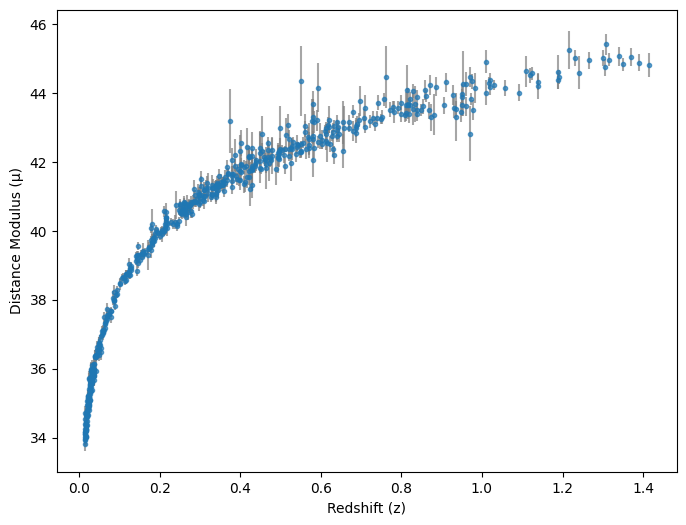

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

data = pd.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')
#data.info()

z = data['redshift']  # redshift
mu = data['dist_mod']  # distance modulus
mu_err = data['dist_mod_error']  # error in distance modulus

plt.figure(figsize=(8, 6))
plt.errorbar(z, mu, yerr=mu_err, fmt='o', markersize=3, ecolor='gray', alpha=0.7)
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.show()


2) Make a function that takes the parameters `p` and the redshift `z`.  It should return the predicted distance modulus.  Use `astropy.cosmology.cosmo.LambdaCDM()` to calculate the luminosity distance.  The parameters should be `p['M']`, `p['Omega_m']` and `p['Omega_Lambda']`.  It is not possible to measure the Hubble parameter independently from `M`, so just set it equal to 70.

In [2]:
import astropy.cosmology as cosmo

def mu_model(p, z):
    cosmology = cosmo.LambdaCDM(H0=70, Om0=p['Omega_m'], Ode0=p['Omega_Lambda'])
    D_L = cosmology.luminosity_distance(z).value
    return 5 * np.log10(D_L) + p['M']


3) Make two functions. One is $\chi^2$ using the data that has been uploaded and assuming the distance moduli are normally distributed.  Also, make `lnprob(p)` ,which returns the log of the Gaussian likelihood and uses the $\chi^2$ function whithin it.

In [3]:
def chi_squared(p):
    model_values = mu_model(p, z)
    return np.sum(((mu - model_values) / mu_err)**2)

def lnprob(p):
    return -0.5 * chi_squared(p)

4) We are going to use the library `lmfit`.  This library handles 
parameters through the class `lmfit.Parameters()`.  Here, create an instance of this class.  Each parameter has a name, an initial guess, whether it is varied, the minimum allowed value and the maximum allowed value.

In [4]:
#!pip install lmfit

In [5]:
import lmfit

params = lmfit.Parameters()
params.add_many(('Omega_m',0.2,True,0,1)
           ,('M', 25.0, True, 20, 30)
           ,('Omega_Lambda',0.7, True, 0, 1)
           )

5) Now we can find the minimum of the chi-squared using `lmfit.minimize()`.

Information on the output of lmfit.minimize() can be found at https://lmfit.github.io/lmfit-py/fitting.html under "MinimizerResult – the optimization result"

In [6]:
mi = lmfit.minimize(chi_squared, params, method='Nelder')
lmfit.printfuncs.report_fit(mi.params)
mi

[[Variables]]
    Omega_m:       0.27913352 (init = 0.2)
    M:             24.9997313 (init = 25)
    Omega_Lambda:  0.72500272 (init = 0.7)


6) Now we can use `lmfit.minimize()` to run multiple Markov chains using the method `emcee`.  (You might have to install the `emcee` library using pip or conda.)  This is not actually a minimization but an MCMC chain.  Run 100 chains of lengths 2000 with burnin periord 500.  Use the minimum chi-square solution above as the initial guess.

This might take a little while to run.  

`emcee` can also be run outside of `lmfit`.  We are using `lmfit` here because it gives a nice way to fix different parameters.

In [7]:
#!pip install emcee==3.0.0 
#!pip install tqdm

In [8]:
result = lmfit.minimize(lnprob, method='emcee',
                     nan_policy='omit',  # this removes non numerical outputs
                     nwalkers=100, burn=500, steps=2000, 
                     params=mi.params,
                     progress=True)
result

100%|██████████| 2000/2000 [01:57<00:00, 17.09it/s]


In [9]:
open_mcmc = pd.DataFrame(result.flatchain, columns=['Omega_m', 'M', 'Omega_Lambda'])
open_mcmc.to_csv('open_mcmc.csv', index=False)

7) Now we can make a nice "corner plot" using the package `corner`.

In [10]:
#!pip install corner

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
M                   25       20       30  0.01357     True     None     None
Omega_Lambda    0.7158        0        1   0.1178     True     None     None
Omega_m         0.2753        0        1     0.07     True     None     None


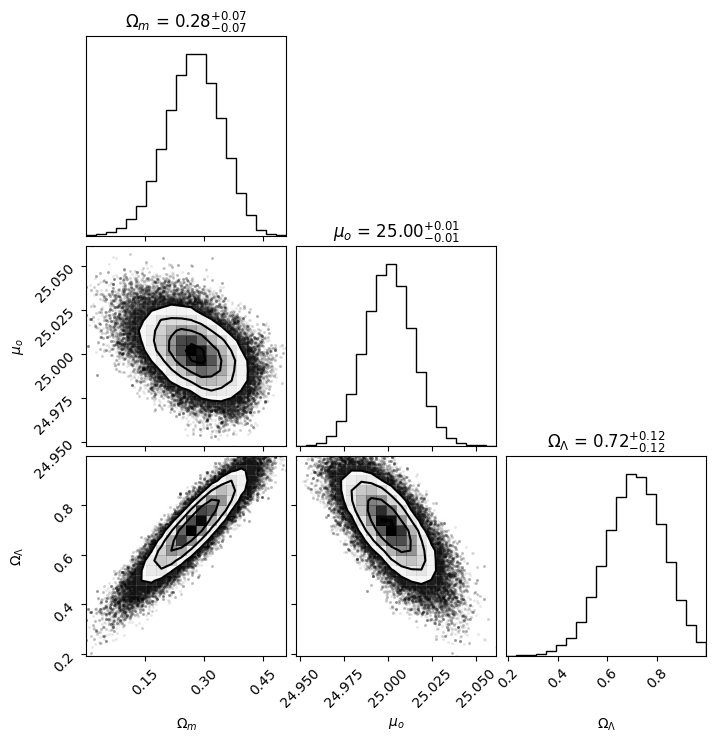

In [11]:
import corner
result.params.pretty_print()
labels=[r'$\Omega_m$', r'$\mu_o$', r'$\Omega_\Lambda$']
fig = corner.corner(result.flatchain,labels=labels,
                     show_titles=True, title_kwargs={"fontsize": 12})

(1500, 100, 3)
(1500,)


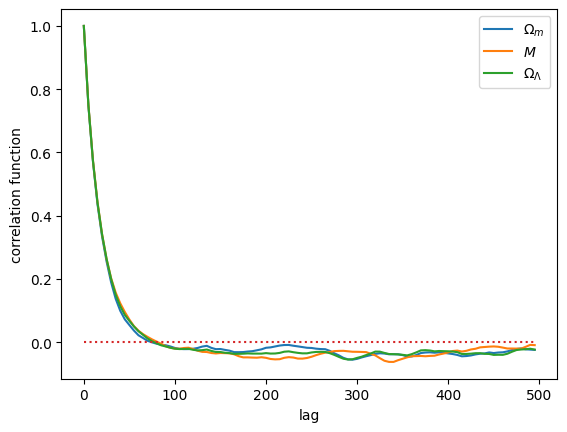

In [12]:
s=np.shape(result.chain)
print(s)
N=s[0]

print(np.shape(result.chain[:,0,0]))
lag = np.arange(0,500,5)
variable_names = [r"$\Omega_m$", r"$M$", r"$\Omega_\Lambda$"]

## there will be three loops here plus a call to np.cov()
 # loop over parameters
for v in range(s[2]):
    corr = np.zeros(len(lag))

    # loop over lags
    for i,n in enumerate(lag):
        cov_sum = 0
        norm_sum = 0

        # loop over chains
        for j in range(s[1]):
            c = np.cov(result.chain[0:N-n,j,v], result.chain[n:N,j,v])
            cov_sum += c[0, 1]
            norm_sum += c[0, 0]

        corr[i] = cov_sum / norm_sum
    
    if v == 2: 
        corr_omega_lambda = corr.copy()

    plt.plot(lag, corr, label=variable_names[v])

plt.legend()
plt.plot([0,lag[-1]],[0,0],linestyle=':')
plt.xlabel('lag')
plt.ylabel('correlation function')
plt.show()

9) If we define the correlation length as the first time the autocorrelation function hits zero, what is this length for $\Omega_\Lambda$ and how many correlation lengths are in each chain?

In [13]:
omega_lambda_corr = next((lag[i] for i, c in enumerate(corr_omega_lambda) if c < 0), None)

print(f"Correlation length for ΩΛ: {omega_lambda_corr}")
print(f"Number of correlation lengths in each chain: {N / omega_lambda_corr}")


Correlation length for ΩΛ: 80
Number of correlation lengths in each chain: 18.75


10) **The maximum likelihood**

Find the entry in the chain with the largest likelihood.  The calculated log-likelihoods as stored in `result.lnprob` (np.argmax() is useful for this).

In [14]:
highest_prob = np.argmax(result.lnprob)
print(highest_prob)
hp_loc = np.unravel_index(highest_prob, result.lnprob.shape)
print(hp_loc)
mle_soln = result.chain[hp_loc]
for i, par in enumerate(params):
    params[par].value = mle_soln[i]

print('\nMaximum Likelihood Estimation from emcee       ')
print('-------------------------------------------------')
print('Parameter  MLE Value   Median Value   Uncertainty')
fmt = '  {:5s}  {:11.5f} {:11.5f}   {:11.5f}'.format
for name, param in params.items():
    print(fmt(name, param.value, result.params[name].value,
              result.params[name].stderr))

75808
(np.int64(758), np.int64(8))

Maximum Likelihood Estimation from emcee       
-------------------------------------------------
Parameter  MLE Value   Median Value   Uncertainty
  Omega_m      0.27864     0.27528       0.07000
  M         24.99995    25.00066       0.01357
  Omega_Lambda      0.72474     0.71584       0.11776


11) We can find quantile ranges for the parameters from `result.flatchain`.

In [15]:
print('\nError estimates from emcee:')
print('------------------------------------------------------')
print('Parameter  -2sigma  -1sigma   median  +1sigma  +2sigma')

for name in params.keys():
    quantiles = np.percentile(result.flatchain[name],
                              [2.275, 15.865, 50, 84.135, 97.275])
    median = quantiles[2]
    err_m2 = quantiles[0] - median
    err_m1 = quantiles[1] - median
    err_p1 = quantiles[3] - median
    err_p2 = quantiles[4] - median
    fmt = '  {:5s}   {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}'.format
    print(fmt(name, err_m2, err_m1, median, err_p1, err_p2))


Error estimates from emcee:
------------------------------------------------------
Parameter  -2sigma  -1sigma   median  +1sigma  +2sigma
  Omega_m    -0.1480  -0.0713   0.2753   0.0687   0.1265
  M        -0.0269  -0.0136  25.0007   0.0136   0.0268
  Omega_Lambda    -0.2460  -0.1198   0.7158   0.1157   0.2110


12) What is the 99% lower credibility limit on $\Omega_\Lambda$?

In [16]:
print(f"99% lower credibility limit on ΩΛ: {np.percentile(result.flatchain['Omega_Lambda'], 1)}")

99% lower credibility limit on ΩΛ: 0.42429046220722033


13) What is posterior probability of $\Omega_m$ being less than 20%.

In [17]:
print(f"Posterior probability of Ωm being less than 20%: {np.mean(result.flatchain['Omega_m'] < 0.2):.4f}")

Posterior probability of Ωm being less than 20%: 0.1460


14) **Compare a flat model to an open model**

The geometrically flat Universe is where $\Omega_m + \Omega_\Lambda=1$.  Thus, a flat model will have one less parameter ($\Omega_\Lambda$ will not be necessary).  Rewrite `mu_model(p,z)`, but now using `cosmo.FlatLambdaCDM()`, redefine `params` to have only two parameters and then find the minimum chi-squared solution.

In [18]:
def mu_model_flat(p, z):
    cosmology = cosmo.FlatLambdaCDM(H0=70, Om0=p['Omega_m'])
    D_L = cosmology.luminosity_distance(z).value
    return 5 * np.log10(D_L) + p['M']

def chi_squared_flat(p):
    model_values = mu_model_flat(p, z)
    chi_sq = np.sum(((mu - model_values) / mu_err)**2)
    return chi_sq

def lnprob_flat(p):
    return -0.5 * chi_squared_flat(p)

params_flat = lmfit.Parameters()
params_flat.add_many(('Omega_m', 0.2, True, 0, 1),
                    ('M', 25.0, True, 20, 30),
                    )

mi_flat = lmfit.minimize(chi_squared_flat, params_flat, method='Nelder')
lmfit.printfuncs.report_fit(mi_flat.params)
mi_flat

[[Variables]]
    Omega_m:  0.27766053 (init = 0.2)
    M:        24.9999365 (init = 25)


15) Does the Bayesian information criterion (BIC) support the conclusion that the Universe is not flat?  (Note that the BIC output when method='emcee' is not valid.  Calculate is yourself.)

In [19]:
n = len(mu)
print(f"Number of data points: {n}")
chisqr_non_flat = chi_squared(mi.params)
chisqr_flat = chi_squared_flat(mi_flat.params)
print(f"\nChi-squared (non-flat): {chisqr_non_flat:.2f}")
print(f"Chi-squared (flat): {chisqr_flat:.2f}")

bic_non_flat = 3 * np.log(n) + chisqr_non_flat
bic_flat = 2 * np.log(n) + chisqr_flat
delta_bic = bic_non_flat - bic_flat

print(f"\nBIC for bic_non_flat model: {bic_non_flat:.2f}")
print(f"BIC for flat model: {bic_flat:.2f}")
print(f"\nDelta BIC: {delta_bic:.2f}")

# Both models have essentially the same chi-squared value (562.23), but the flat model uses one fewer parameter. 
# The BIC penalizes the non-flat model for its extra parameter.

# Since the flat model has a much lower BIC and absolute difference > 6,it is strongly preferred over the non-flat model.
# The BIC does not support the conclusion that the Universe is not flat. Instead, it strongly supports a flat Universe where Ωm + ΩΛ = 1.

print("\nSince the flat model has a lower BIC and absolute difference > 6,it is strongly preferred over the non-flat model.")
print("Hence, The BIC does not support the conclusion that the Universe is not flat. Instead, it strongly supports a flat Universe where Ωm + ΩΛ = 1.")


Number of data points: 580

Chi-squared (non-flat): 562.23
Chi-squared (flat): 562.23

BIC for bic_non_flat model: 581.32
BIC for flat model: 574.95

Delta BIC: 6.36

Since the flat model has a lower BIC and absolute difference > 6,it is strongly preferred over the non-flat model.
Hence, The BIC does not support the conclusion that the Universe is not flat. Instead, it strongly supports a flat Universe where Ωm + ΩΛ = 1.


16) Redo the MCMC with this two-parameter model.

In [20]:
result_flat = lmfit.minimize(lnprob_flat, method='emcee',
                             nan_policy='omit',  # this removes non numerical outputs
                             nwalkers=100, burn=500, steps=2000,
                             params=params_flat,
                             progress=True)

result_flat

100%|██████████| 2000/2000 [02:01<00:00, 16.48it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [40.47682362 33.75758908]


In [21]:
flat_mcmc = pd.DataFrame(result_flat.flatchain, columns=['Omega_m', 'M'])
flat_mcmc.to_csv('flat_mcmc.csv', index=False)

17) Make a corner plot for this model. 

Name        Value      Min      Max   Stderr     Vary     Expr Brute_Step
M              25       20       30  0.01055     True     None     None
Omega_m    0.2783        0        1  0.01958     True     None     None


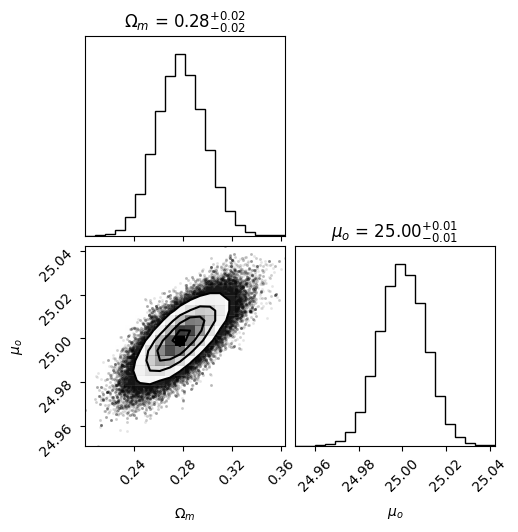

In [22]:
result_flat.params.pretty_print()
labels=[r'$\Omega_m$', r'$\mu_o$']
fig = corner.corner(result_flat.flatchain,labels=labels,
                     show_titles=True, title_kwargs={"fontsize": 12})

18) What is the 99% lower credibility limit on $\Omega_\Lambda$ within flat models? 

In [23]:
print(f"99% lower credibility limit on ΩΛ: {1 - np.percentile(result_flat.flatchain['Omega_m'], 99)}")

99% lower credibility limit on ΩΛ: 0.6750502211911213
